Lesson 7 - Applied Regression Modeling -  Diagnostics for Multiple Linear Regression

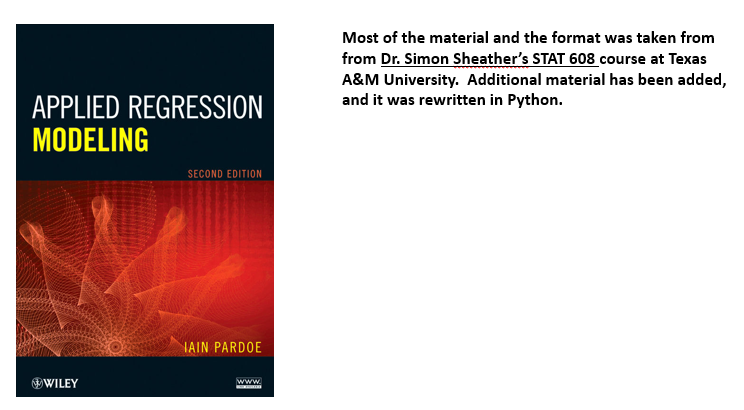

<b>ATTRIBUTION/ CITATION:</b> Most of this material including the course outline was taken from Dr. Simon Sheather's STAT 608 course at Texas A&M University. However, it uses additional examples and was adopted for use with Python. In addition, much of the course material used the textbook Applied Regression Modeling by Iain Pardoe. 

- We saw that when we use a multiple linear regression model we implicitly make a series of assumptions.
- We consider a series of tools known as regression diagnostics to check each assumption.
- We need to understand what actually happens when the standard assumptions associated with a regression model are violated, and what should be done in response to each violation

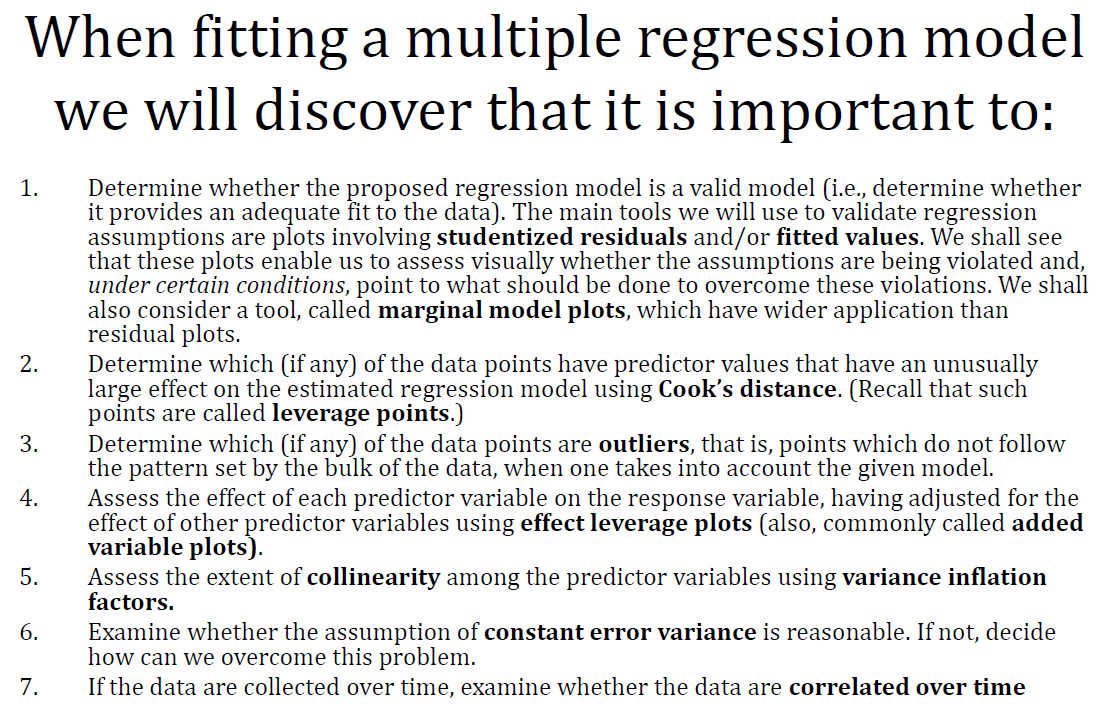

# In this exercise we will be using data from the National Football League (NFL) to determine if data on recieving yards in 2019 can predict the outcome of touchdowns by those recieving players in 2019. 

We have player stats data that is scraped from the following online sources
- https://www.nfl.com/stats/player-stats/
- https://www.nfl.com/players/

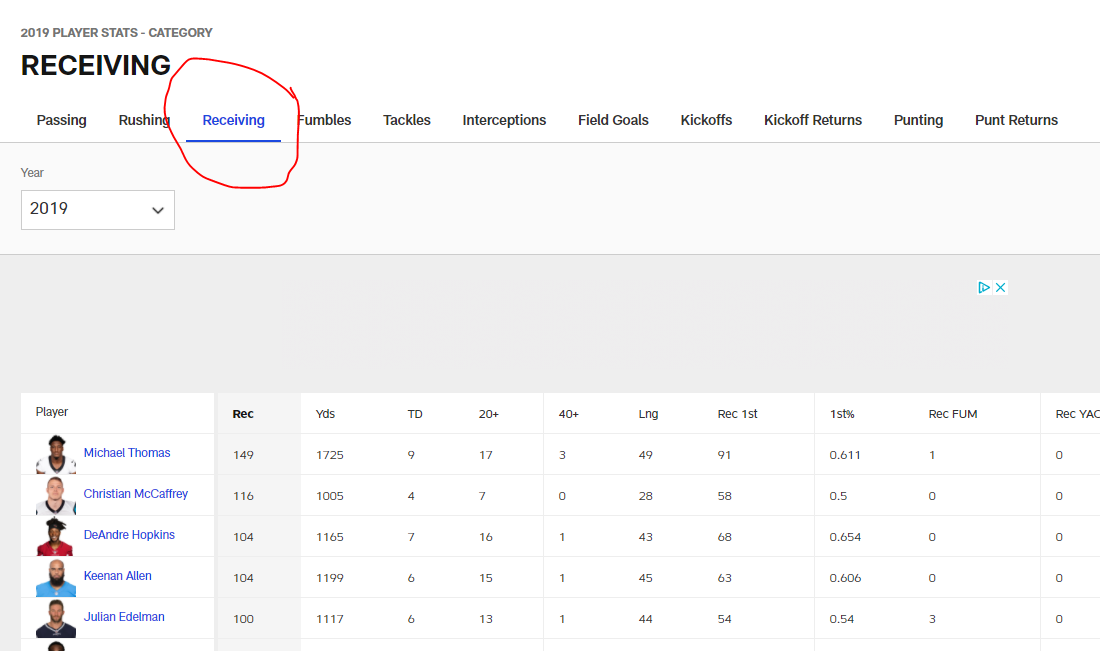

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

from matplotlib import pyplot as plt
import statsmodels.api as sm    
from bs4 import BeautifulSoup
import urllib.request
import matplotlib.ticker as ticker

import warnings
warnings.filterwarnings('ignore')

# display settings

In [40]:
pd.options.display.max_rows = 100        #Increases the number of rows displayed without a break in the middle.
pd.options.display.max_columns = 100     #Increases the number of columns displayed without a break in the middle.
pd.set_option('max_colwidth',100)        #Increases the width of the columns to display 100 characters at the same time.

# definitions

In [41]:
def find_next_url(url, keyword):

    links = []
    parser = 'html.parser'  # or 'lxml' (preferred) or 'html5lib', if installed
    resp = urllib.request.urlopen(url)
    soup = BeautifulSoup(resp, parser, from_encoding=resp.info().get_param('charset'))

    for link in soup.find_all('a', href=True):
        links.append(link['href'])

    next_url = 'https://www.nfl.com'+str([link for link in links if str(keyword) in link][0])
    
    return next_url

In [42]:
def get_players(url, players, letter, keyword):

    #print('Downloading players with last names starting with {} at url: {}'.format(letter, url))
    download = pd.read_html(url)[0]
    objs = [players,download]
    players = pd.concat(objs, axis=0, join='outer', 
                        ignore_index=False, keys=None, levels=None, 
                        names=None, verify_integrity=False, copy=True)    

    # NOTE: recursively iterates to the next URL at the bottom of the page.
    try:
        next_url = find_next_url(url, keyword)
        
        if next_url == 'https://www.nfl.com/players/active/{}?query={}&after='.format(letter,letter):
            return players
        
        else: 
            url = next_url
            players = get_players(url, players, letter, keyword)
        
    except:
        return players
    
    return players

In [43]:
def get_nfl_player_directory(save_to_pickle = True):

    players = pd.DataFrame()

    for letter in [chr(x) for x in range(ord('a'), ord('z') + 1)]:

        #primary url
        url = 'https://www.nfl.com/players/active/{}'.format(letter)
        keyword = 'aftercursor'
        players = get_players(url, players, letter, keyword)
    
    if save_to_pickle:
        
        # Save as a pickle file
        players.to_pickle('./nfl_player_directory.pkl')
    
    return players  

In [44]:
def get_player_stats(url, statistics):

    download = pd.read_html(url)[0]
    objs = [statistics,download]
    statistics = pd.concat(objs, axis=0, join='outer', 
                        ignore_index=False, keys=None, levels=None, 
                        names=None, verify_integrity=False, copy=True)    

    # NOTE: recursively iterates to the next URL at the bottom of the page.
    try:
        next_url = find_next_url(url, keyword = 'aftercursor')
        statistics = get_player_stats(next_url, statistics)          
        return statistics
    
    except:
        return statistics
    
#    return statistics

In [45]:
def get_nfl_player_stats(year, first_category, second_category, save_to_pickle = True):
    
    statistics = pd.DataFrame()
    url = 'https://www.nfl.com/stats/player-stats/category/{}/{}/REG/all/{}/desc'.format(first_category, year, second_category)
    statistics = get_player_stats(url, statistics)
    
    # write the year to the columns
    for col in list(statistics.columns)[1:]:

        remove_words = ['rush', 'pass', 'rec']
        adj_col = col
        for word in remove_words:
            adj_col = str(adj_col).lower().replace(word,'').strip(' ') 
        #debugging   
        #print(col,' --> ', adj_col)
        statistics = statistics.rename(columns = {col:'{}_{}_{}'.format(first_category.lower(),adj_col.lower(), year)})
        
    if save_to_pickle:
        
        # Save as a pickle file
        statistics.to_pickle('./nfl_player_stats_{}_{}.pkl'.format(first_category, year))
    
    
    return statistics

In [46]:
def draw_correlations(data):
    
    import statsmodels.api as sm 
 
    print('\nScatterplot Matrix\n')
    corr = data.corr()
    c = corr.style.background_gradient(cmap='Blues')
    display(c)

    print('\n')
    g = sns.pairplot(data, diag_kind="kde", corner=False, height = 2.5)
    g = g.map_lower(sns.kdeplot, levels=4, color=".2")

In [47]:
def get_vifs(X):
    
    from statsmodels.stats.outliers_influence import variance_inflation_factor
        
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    
    return vif

# Get player roster

In [48]:
if os.path.exists('./nfl_player_directory.pkl'):
    nfl_player_directory = pd.read_pickle('./nfl_player_directory.pkl')
    print("Yay! It's there!")

else:
    nfl_player_directory = get_nfl_player_directory(save_to_pickle = True)
print('Length of the dataset is ', len(nfl_player_directory))

display(nfl_player_directory.head(20))
display(nfl_player_directory.tail(20))

Yay! It's there!
Length of the dataset is  2877


,Player,Current Team,Position,Status
0,Chidobe Awuzie,Dallas Cowboys,CB,RES
1,Josh Avery,Seattle Seahawks,DT,ACT
2,Genard Avery,Philadelphia Eagles,DE,RES
3,Anthony Averett,Baltimore Ravens,CB,RES
4,Lee Autry,Los Angeles Chargers,DT,CUT
5,Denico Autry,Indianapolis Colts,DT,ACT
6,Tavon Austin,San Francisco 49ers,WR,CUT
7,Blessuan Austin,New York Jets,CB,ACT
8,Antony Auclair,Tampa Bay Buccaneers,TE,ACT
9,Jeremiah Attaochu,Denver Broncos,OLB,ACT


,Player,Current Team,Position,Status
0,Trevon Young,Cleveland Browns,DE,RES
1,Sam Young,Las Vegas Raiders,OT,ACT
2,Kenny Young,Los Angeles Rams,OLB,ACT
3,Chase Young,Washington Football Team,DE,ACT
4,Bryson Young,Atlanta Falcons,DE,ACT
5,Isaac Yiadom,New York Giants,CB,ACT
6,T.J. Yeldon,Buffalo Bills,RB,ACT
7,Deon Yelder,Kansas City Chiefs,TE,ACT
8,Rock Ya-Sin,Indianapolis Colts,CB,ACT
9,Eddie Yarbrough,Minnesota Vikings,DE,DEV


## scrape/ load recieving data from the NFL website

In [49]:
# params
year = 2019
first_category = 'receiving'
second_category = 'receivingreceptions'

# get the data
if os.path.exists('./nfl_player_stats_{}_{}.pkl'.format(first_category,year)):
    recieving_data = pd.read_pickle('./nfl_player_stats_{}_{}.pkl'.format(first_category,year))
    print("Yay! It's there!")

else:
    recieving_data = get_nfl_player_stats(year, first_category, second_category, save_to_pickle = True)
print('Length of the dataset is ', len(recieving_data))

# select relevant columns
recieving_data = recieving_data[['Player','receiving_td_2019','receiving_yds_2019', 'receiving__2019','receiving_tgts_2019']]
recieving_data = recieving_data.rename(columns = {'receiving_td_2019':'receiving_touchdowns_2019',
                                                  'receiving_yds_2019':'receiving_yards_2019',
                                                  'receiving__2019':'received_passes_2019',
                                                  'receiving_tgts_2019':'pass_targets_2019'})
display(recieving_data.head(4))
display(recieving_data.tail(4))

Yay! It's there!
Length of the dataset is  491


,Player,receiving_touchdowns_2019,receiving_yards_2019,received_passes_2019,pass_targets_2019
0,Michael Thomas,9,1725,149,185
1,Christian McCaffrey,4,1005,116,142
2,DeAndre Hopkins,7,1165,104,150
3,Keenan Allen,6,1199,104,149


,Player,receiving_touchdowns_2019,receiving_yards_2019,received_passes_2019,pass_targets_2019
12,David Blough,1,19,1,1
13,Antony Auclair,0,11,1,3
14,Javorius Allen,0,9,1,2
15,Jamal Agnew,0,0,1,2


# Plot the touchdowns against recieving yards, recieving, recieving targets. 

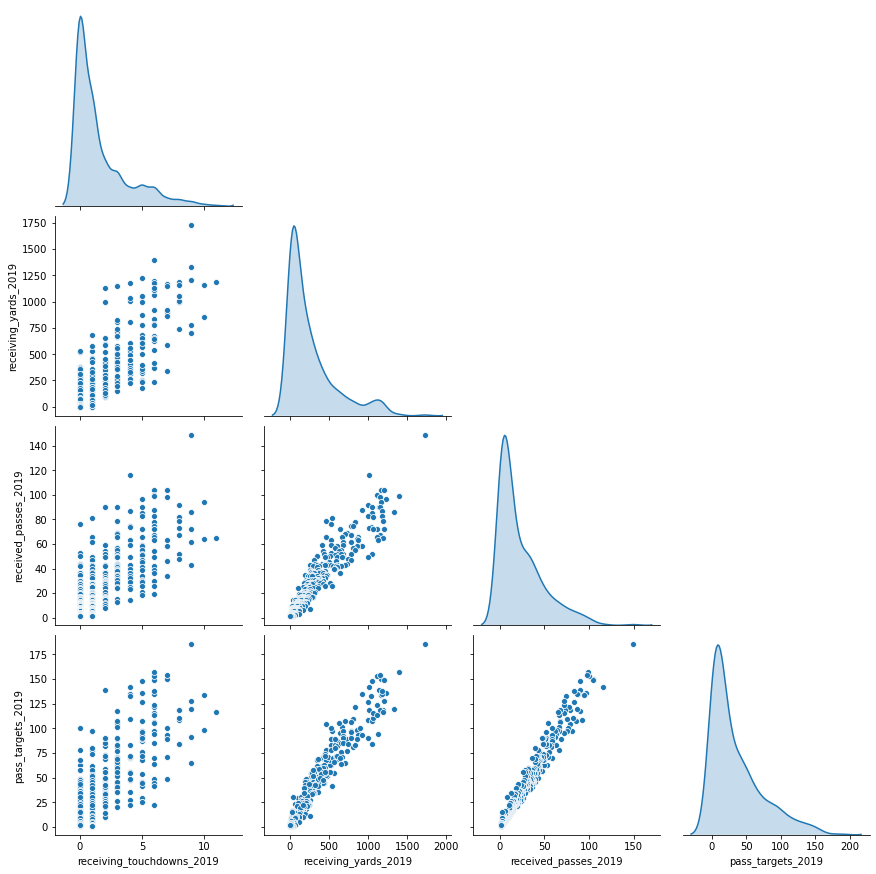

In [64]:
plot_data = recieving_data[['receiving_touchdowns_2019','receiving_yards_2019', 'received_passes_2019','pass_targets_2019']]
g = sns.pairplot(plot_data, diag_kind="kde", corner=True, height = 3)

### What do we see?

 - The three plots of recieving yards, recieved passes and pass targets against touchdowns show positive associations.
 - The plot of recieving yards, recieved passes, pass targets looks approximately linear. 

# "Shoot a line".... step by step

### Step1: Import the module and assign the data

In [68]:
import statsmodels.api as sm   
df = recieving_data.copy()

### Step 2: target column 'y'

In [69]:
y = df['receiving_touchdowns_2019'].copy()
y

0     9
1     4
2     7
3     6
4     6
     ..
11    0
12    1
13    0
14    0
15    0
Name: receiving_touchdowns_2019, Length: 491, dtype: int64

### Step 3: predictor columns 'X'
Using a capital letter X denotes a matrix while lower case x denotes a vector or column vector

In [70]:
X = df[['receiving_yards_2019','received_passes_2019', 'pass_targets_2019']]
X

,receiving_yards_2019,received_passes_2019,pass_targets_2019
0,1725,149,185
1,1005,116,142
2,1165,104,150
3,1199,104,149
4,1117,100,153
...,...,...,...
11,0,1,1
12,19,1,1
13,11,1,3
14,9,1,2


### Step 4: add a constant

In [71]:
X = sm.add_constant(X) 
X.head()

,const,receiving_yards_2019,received_passes_2019,pass_targets_2019
0,1.0,1725,149,185
1,1.0,1005,116,142
2,1.0,1165,104,150
3,1.0,1199,104,149
4,1.0,1117,100,153


The constant is column of 1's. 

y = (Coefficient)* x + (Coefficient) * 1

y = (m)x + b*1

### Step 5: assign the model type

In [56]:
ols_model = sm.OLS(y, X)

### Step 6: fit the coefficients in the model
This is just the OLS model again, but it calculates the coefficients. <i>It's been renamed "fitted"</i>

In [57]:
# This is just the OLS model again, but it calculates the coefficients. 
fitted = ols_model.fit()

### Step 7: make predictions

In [58]:
yhat = fitted.predict(X)
df['predicted'] = yhat

### Step 8: get model diagnostic data

In [59]:
df['residuals'] = y - yhat                                                  # residuals
influence                   = fitted.get_influence()                        # get diagnostic data
df['studentized_residuals'] = influence.resid_studentized_external          # studentized residuals
df['cooks_distance']        = influence.cooks_distance[0]                   # cook's distance

### Step 9 print the model summary

In [60]:
summary = fitted.summary() 
print(summary)

                                OLS Regression Results                               
Dep. Variable:     receiving_touchdowns_2019   R-squared:                       0.701
Model:                                   OLS   Adj. R-squared:                  0.699
Method:                        Least Squares   F-statistic:                     380.2
Date:                       Thu, 12 Nov 2020   Prob (F-statistic):          3.79e-127
Time:                               09:36:52   Log-Likelihood:                -794.24
No. Observations:                        491   AIC:                             1596.
Df Residuals:                            487   BIC:                             1613.
Df Model:                                  3                                         
Covariance Type:                   nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [61]:
df

,Player,receiving_touchdowns_2019,receiving_yards_2019,received_passes_2019,pass_targets_2019,predicted,residuals,studentized_residuals,cooks_distance
0,Michael Thomas,9,1725,149,185,10.452093,-1.452093,-1.268307,0.057411
1,Christian McCaffrey,4,1005,116,142,5.477926,-1.477926,-1.253211,0.030318
2,DeAndre Hopkins,7,1165,104,150,6.706023,0.293977,0.242773,0.000369
3,Keenan Allen,6,1199,104,149,6.995477,-0.995477,-0.822532,0.004197
4,Julian Edelman,6,1117,100,153,6.293402,-0.293402,-0.242671,0.000415
...,...,...,...,...,...,...,...,...,...
11,Garrett Bradbury,0,0,1,1,0.132311,-0.132311,-0.108127,0.000011
12,David Blough,1,19,1,1,0.285473,0.714527,0.584205,0.000352
13,Antony Auclair,0,11,1,3,0.190231,-0.190231,-0.155451,0.000022
14,Javorius Allen,0,9,1,2,0.189485,-0.189485,-0.154845,0.000022


## Remove the insignificant value and "shoot a line"

In [72]:
df = recieving_data.copy()                                               # assign the data
y = df['receiving_touchdowns_2019'].copy()                               # target column y
X = df[['receiving_yards_2019','pass_targets_2019']]                     # predictor columns 
X = sm.add_constant(X) 
ols_model = sm.OLS(y, X)                                                 # assign the model architecture 
fitted = ols_model.fit()                                                 # fit the model
yhat = fitted.predict(X)                                                 # predict the model
df['predicted'] = yhat                                                   # assign predicted
df['residuals'] = y - yhat                                               # calculate and assign residuals
influence                   = fitted.get_influence()                     # get diagnostic data
df['studentized_residuals'] = influence.resid_studentized_external       # studentized residuals
df['cooks_distance']        = influence.cooks_distance[0]                # cook's distance
summary = fitted.summary() 
print(summary)

                                OLS Regression Results                               
Dep. Variable:     receiving_touchdowns_2019   R-squared:                       0.701
Model:                                   OLS   Adj. R-squared:                  0.699
Method:                        Least Squares   F-statistic:                     571.1
Date:                       Thu, 12 Nov 2020   Prob (F-statistic):          1.53e-128
Time:                               10:14:46   Log-Likelihood:                -794.33
No. Observations:                        491   AIC:                             1595.
Df Residuals:                            488   BIC:                             1607.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [63]:
df = recieving_data.copy()                                               # assign the data
y = df['receiving_touchdowns_2019'].copy()                               # target column y
X = df[['received_passes_2019']]                                         # predictor columns 

ols_model = sm.OLS(y, X)                                                 # assign the model architecture 
fitted = ols_model.fit()                                                 # fit the model
yhat = fitted.predict(X)                                                 # predict the model
df['predicted'] = yhat                                                   # assign predicted
df['residuals'] = y - yhat                                               # calculate and assign residuals
influence                   = fitted.get_influence()                     # get diagnostic data
df['studentized_residuals'] = influence.resid_studentized_external       # studentized residuals
df['cooks_distance']        = influence.cooks_distance[0]                # cook's distance
summary = fitted.summary() 
print(summary)

                                    OLS Regression Results                                    
Dep. Variable:     receiving_touchdowns_2019   R-squared (uncentered):                   0.731
Model:                                   OLS   Adj. R-squared (uncentered):              0.730
Method:                        Least Squares   F-statistic:                              1330.
Date:                       Thu, 12 Nov 2020   Prob (F-statistic):                   9.72e-142
Time:                               09:46:16   Log-Likelihood:                         -872.65
No. Observations:                        491   AIC:                                      1747.
Df Residuals:                            490   BIC:                                      1751.
Df Model:                                  1                                                  
Covariance Type:                   nonrobust                                                  
                           coef    std err        

### Observations
Notice that the Analysis of Variance produces a highly statistically significant result. All of the predictors are statistically significant (except the constant). However, the coefficient of <b>received_passes_2019</b> is negative . What is going on?

### Explanation

- All of the predictors are statistically significant. However, the coefficient of <b>received_passes_2019</b> is negative. In other words, having adjusted for the effects of <b>receiving_yards_2019</b>, <b>received_passes_2019</b> is negative. 

### Redo the fit as a bivariate plot with received passes to predict touchdowns with the constant

In [65]:
df = recieving_data.copy()                                          # assign the data
y = df['receiving_touchdowns_2019'].copy()                          # target column y
x = df[['received_passes_2019']].copy()                             # predictor columns
x = sm.add_constant(x)                                              # add constant
ols_model = sm.OLS(y, x)                                            # assign the model architecture
fitted = ols_model.fit()                                            # fit the model
yhat = fitted.predict(x)                                            # predict the model
df['predicted'] = yhat                                              # assign predicted
df['residuals'] = y - yhat                                          # calculate and assign residuals
influence                   = fitted.get_influence()                # get diagnostic data
df['studentized_residuals'] = influence.resid_studentized_external  # studentized residuals
df['cooks_distance']        = influence.cooks_distance[0]           # cook's distance
summary = fitted.summary()                                          # make the summary

print(summary)

                                OLS Regression Results                               
Dep. Variable:     receiving_touchdowns_2019   R-squared:                       0.588
Model:                                   OLS   Adj. R-squared:                  0.587
Method:                        Least Squares   F-statistic:                     698.7
Date:                       Thu, 12 Nov 2020   Prob (F-statistic):           2.79e-96
Time:                               09:54:27   Log-Likelihood:                -872.59
No. Observations:                        491   AIC:                             1749.
Df Residuals:                            489   BIC:                             1758.
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

##  Recieved passes in 2019 now has a positive effect on touchdowns! What's going on??

What we need is a plot that shows the effect of <b>received_passes_2019</b> on touchdowns , having adjusted both
for the effects of the other predictors. We consider such a plot next, known as an <b>Effect Leverage Plot</b>, <b>Added Variable Plot</b>, or <b>Partial Regression Plot</b>

<i>a partial regression plot attempts to show the effect of adding another variable to a model that already has one or more independent variables. Partial regression plots are also referred to as added variable plots, adjusted variable plots, and individual coefficient plots.</i>

Wikipedia: https://en.wikipedia.org/wiki/Partial_regression_plot

In [66]:
df = recieving_data.copy()
y = df['receiving_touchdowns_2019']                                            # target column y               
X = df[['receiving_yards_2019','received_passes_2019','pass_targets_2019']]    # predictor columns
X = sm.add_constant(X)                                                         # add constant
ols_model = sm.OLS(y, X)                                                       # assign the model architecture
fitted = ols_model.fit()                                                       # fit the model
yhat = fitted.predict(X)                                                       # predict the model
df['predicted'] = yhat                                                         # assign predicted
df['residuals'] = y - yhat                                                     # calculate and assign residuals
influence                   = fitted.get_influence()                           # get diagnostic data
df['studentized_residuals'] = influence.resid_studentized_external             # studentized residuals
df['cooks_distance']        = influence.cooks_distance[0]                      # cook's distance
summary = fitted.summary()                                                     # make the summary

print(summary)

                                OLS Regression Results                               
Dep. Variable:     receiving_touchdowns_2019   R-squared:                       0.701
Model:                                   OLS   Adj. R-squared:                  0.699
Method:                        Least Squares   F-statistic:                     380.2
Date:                       Thu, 12 Nov 2020   Prob (F-statistic):          3.79e-127
Time:                               09:55:17   Log-Likelihood:                -794.24
No. Observations:                        491   AIC:                             1596.
Df Residuals:                            487   BIC:                             1613.
Df Model:                                  3                                         
Covariance Type:                   nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

## Partial Regression Plot 
It's a plot where we have adjusted everything for the other predictors. If I want to examine the relationship between Y and X3, then I need to remove all the other relationships and look at the piece that is added X3 into the model. What happens when you add X3 into the model?


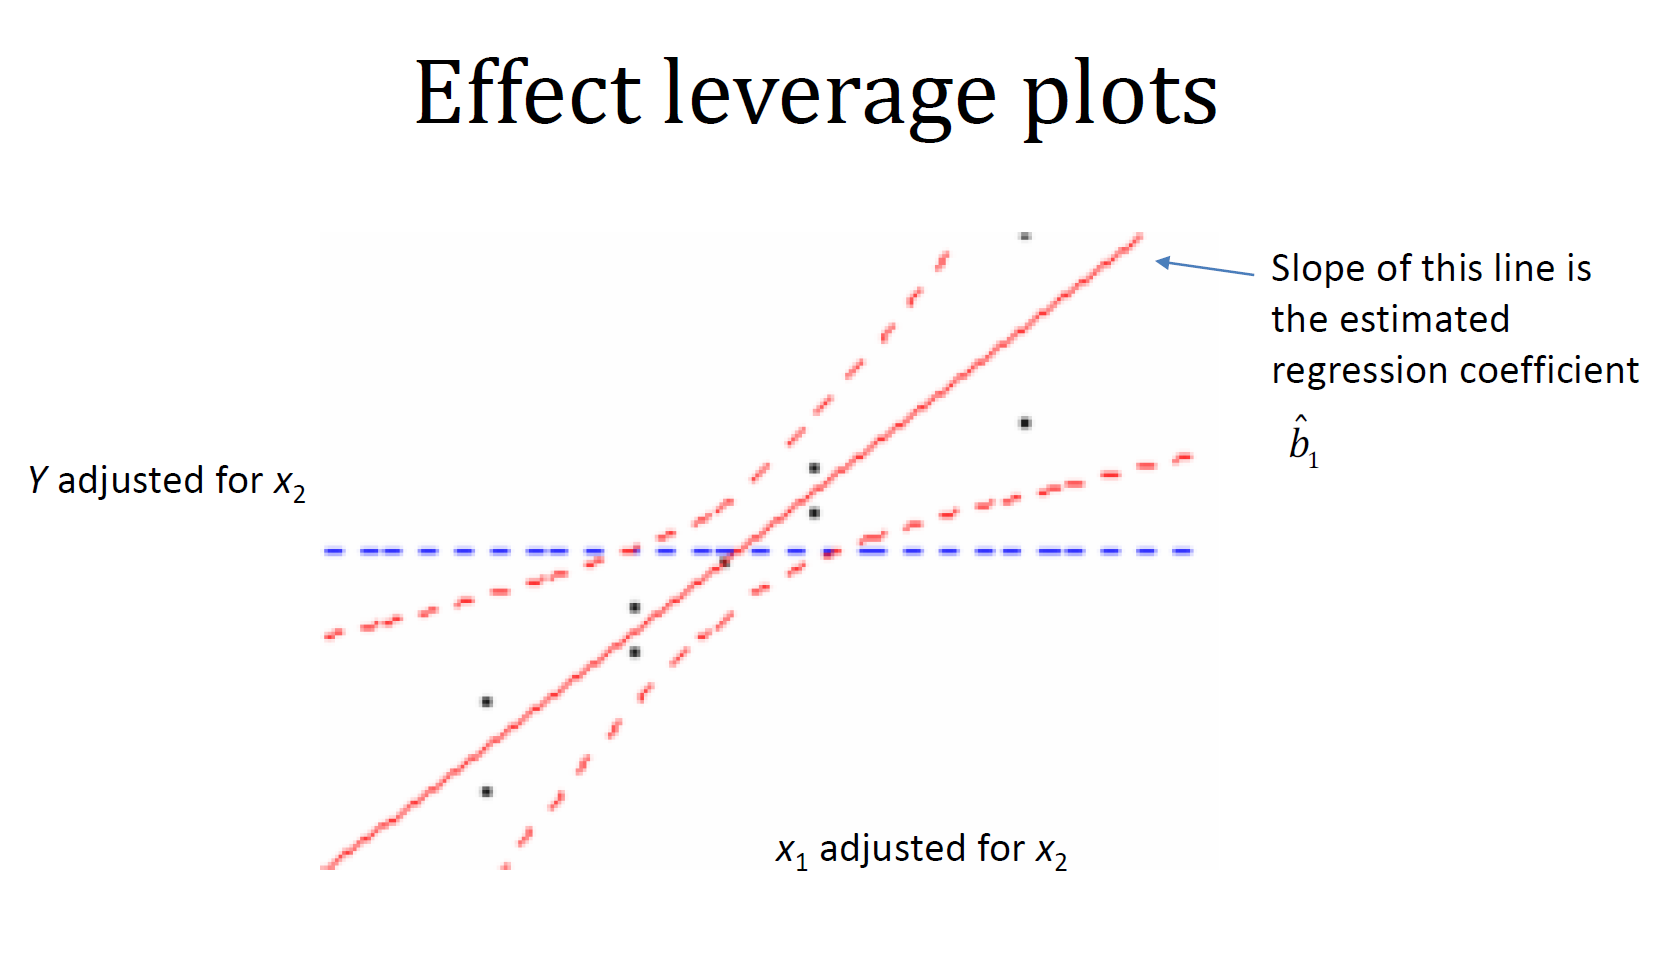

That slope is the regression coefficient in your multiple regression.  So if we see 2.0 we will see 2.0 as the regression coefficient having adjusted for the other predictors. It's a very clever plot!

### Leverage Plots
An effect leverage plot for X is useful in the following ways:
- You can see which points might be exerting influence on the hypothesis test for X.
- You can spot unusual patterns and violations of the model assumptions.
- You can spot multicollinearity issues.


### Construction
<p>
A leverage plot for an effect shows the impact of adding this effect to the model, given the other effects already in the model. For illustration, consider the construction of an effect leverage plot for a single continuous effect X. 
</p>
<p>
The response Y is regressed on all the predictors except X, and the residuals are obtained. Call these residuals the Y-residuals. Then X is regressed on all the other predictors in the model and the residuals are computed. Call these residuals the X-residuals. The X-residuals might contain information beyond what is present in the Y-residuals, which were obtained without X in the model.
</p>
<p>
The effect leverage plot for X is essentially a scatterplot of the X-residuals against the Y-residuals (Whole Model and Effect Leverage Plots). To help interpretation and comparison with other plots that you might construct, JMP adds the mean of Y to the Y-residuals and the mean of X to the X-residuals. The translated Y-residuals are called the Y Leverage Residuals and the translated X-residuals are called X Leverage values. The points on the Effect Leverage plots are these X Leverage and Y Leverage Residual pairs.
</p>
<p>


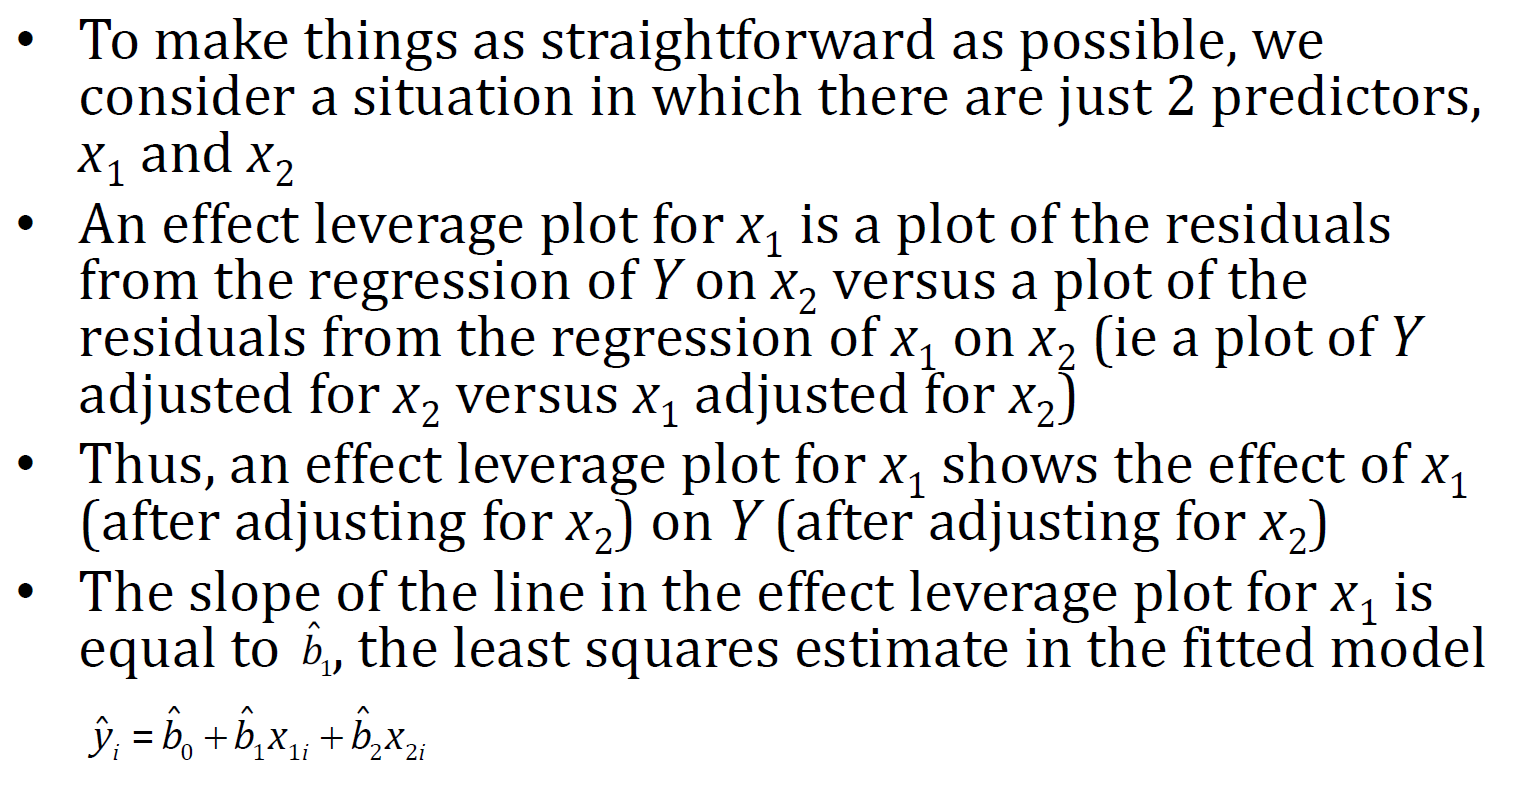

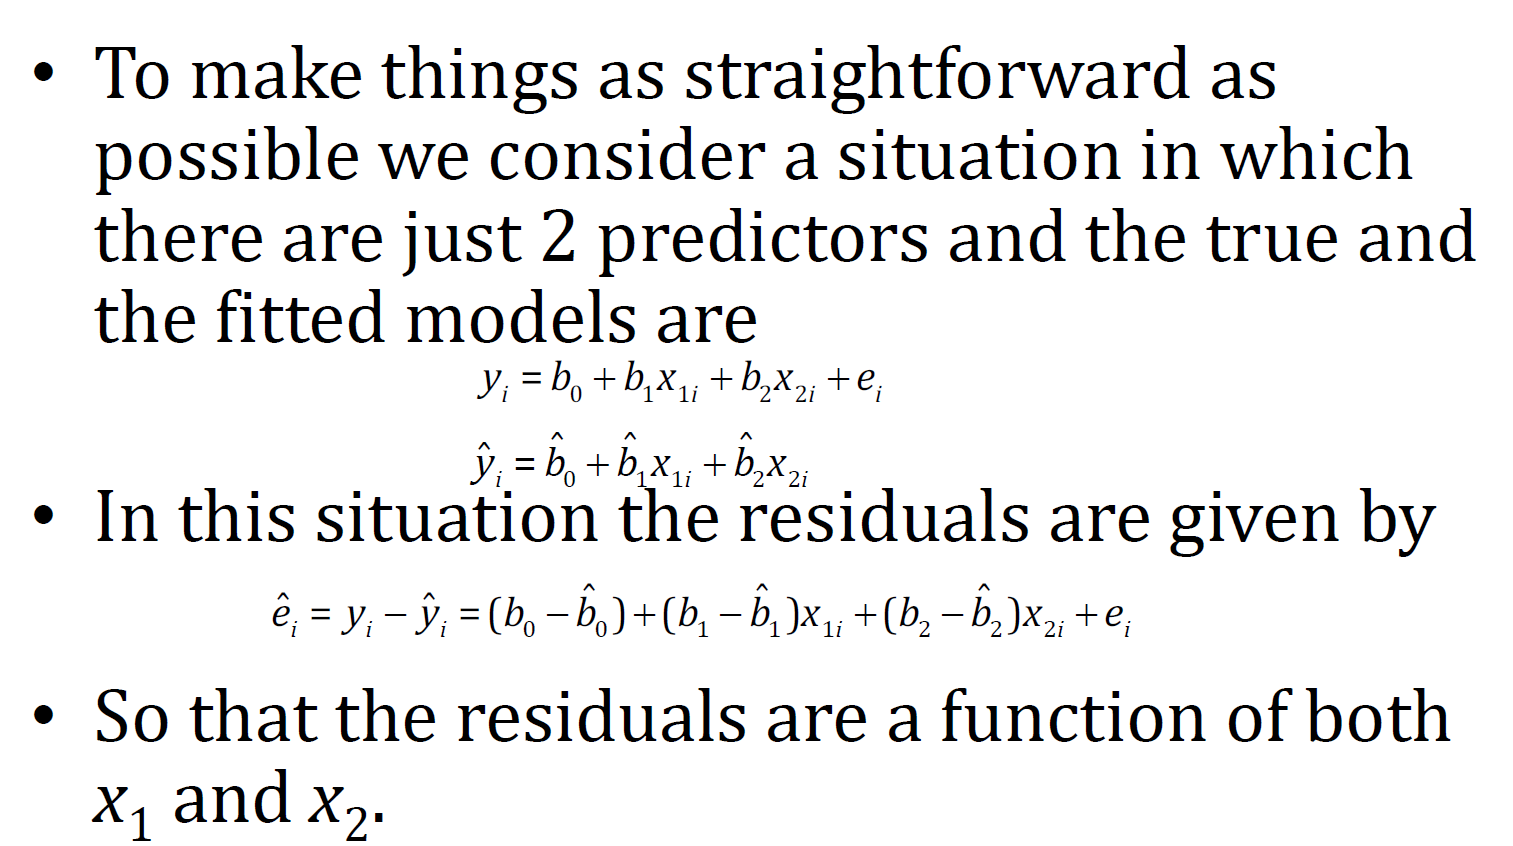

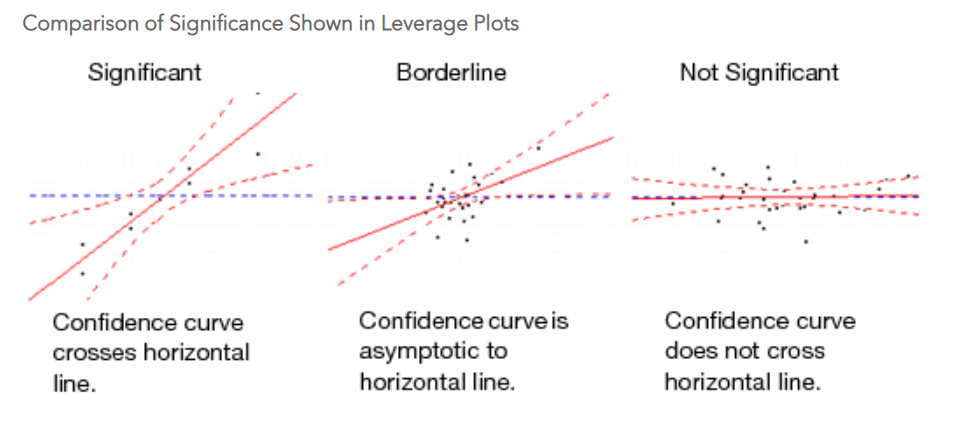

# How do we do this in Python?

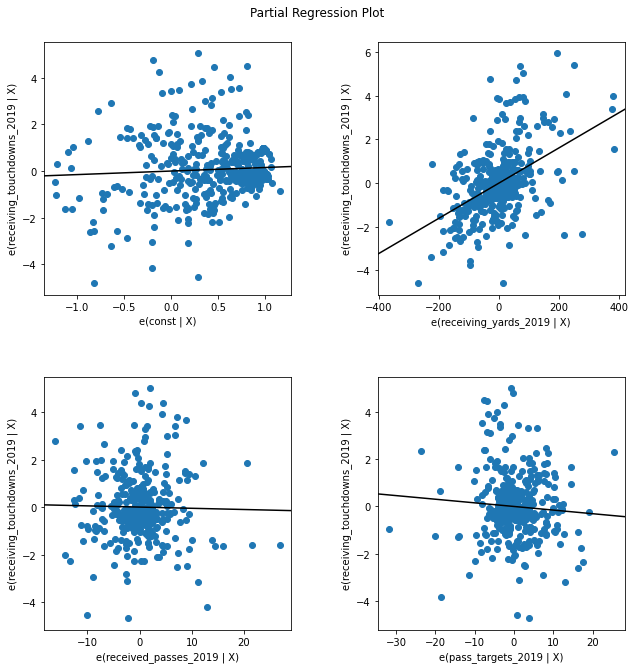

In [67]:
#from matplotlib import rc
fig = plt.figure(figsize=(10,10))
fig = sm.graphics.plot_partregress_grid(fitted, fig = fig)
fig.tight_layout(pad=5)

# let's look at the partial regression again.

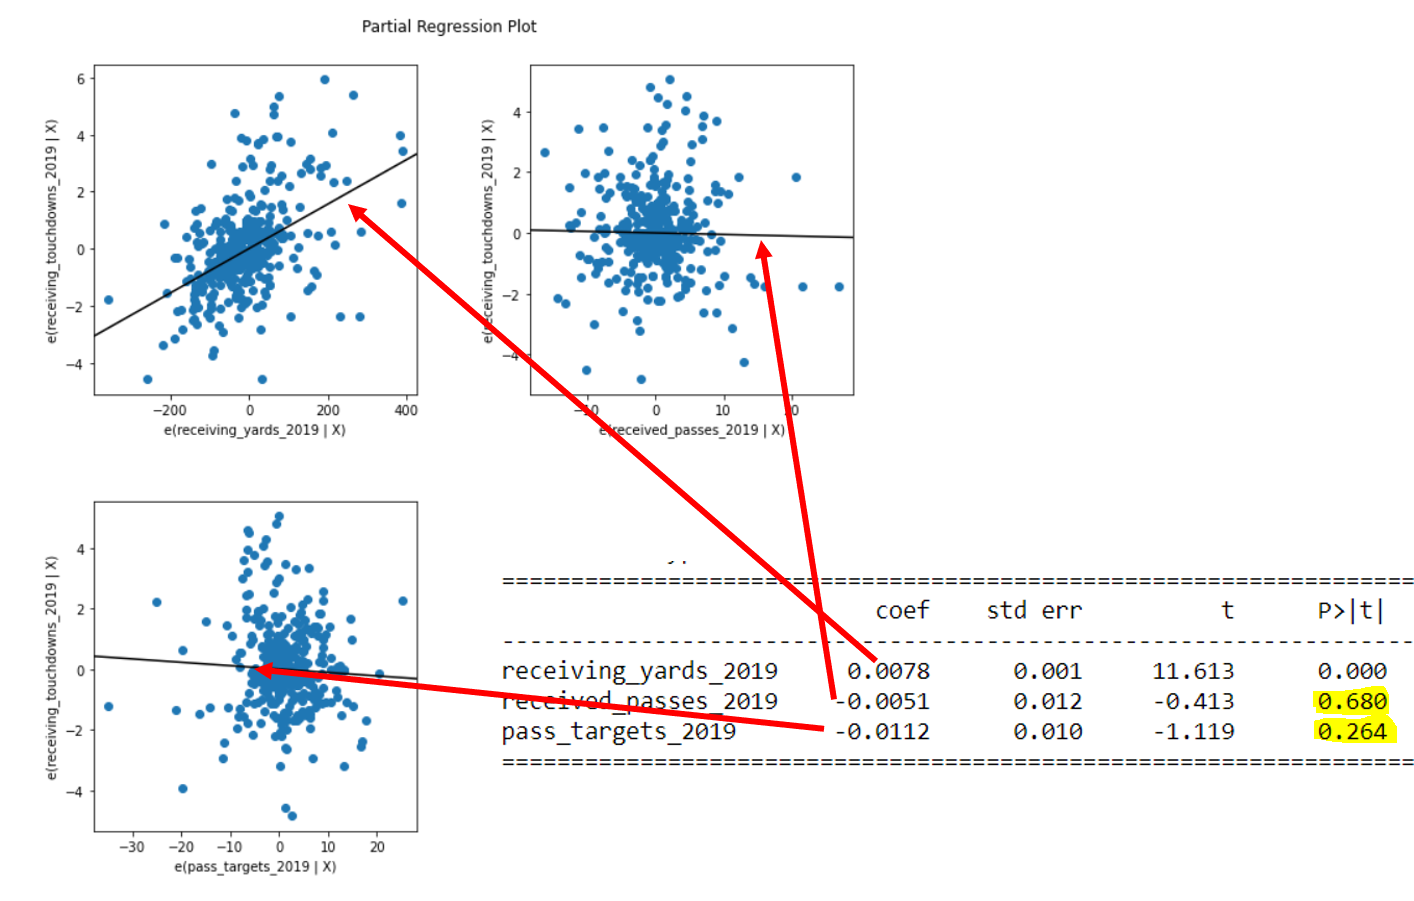

# observation of residual plots

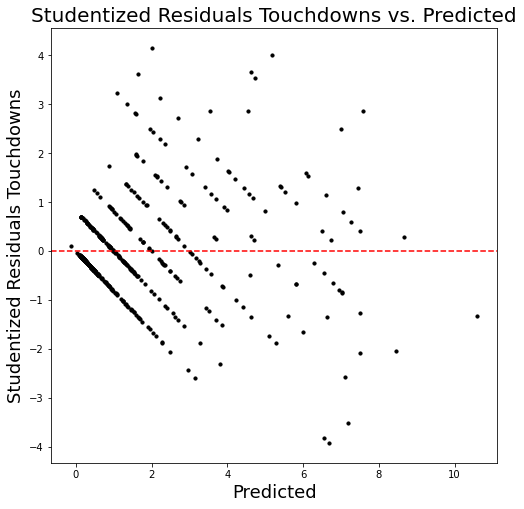

In [73]:
plt.figure(figsize = (8,8))
plt.scatter(df.predicted, df.studentized_residuals, s = 10, color = 'black')
plt.title('Studentized Residuals Touchdowns vs. Predicted', fontsize = 20)
plt.axhline(y=0, color = 'red', linestyle = '--')
plt.xlabel('Predicted', fontsize = 18)
plt.ylabel('Studentized Residuals Touchdowns', fontsize = 18)
plt.show()


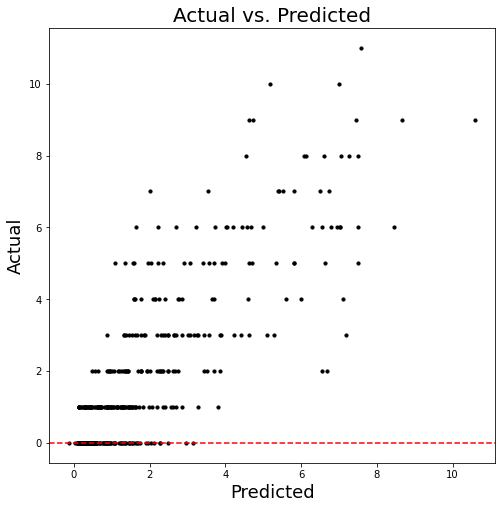

In [75]:
plt.figure(figsize = (8,8))
plt.scatter(df.predicted, df.receiving_touchdowns_2019, s = 10, color = 'black')
plt.title('Actual vs. Predicted', fontsize = 20)
plt.axhline(y=0, color = 'red', linestyle = '--')
plt.xlabel('Predicted', fontsize = 18)
plt.ylabel('Actual', fontsize = 18)
plt.show()


# observations of residual plots
- The plot of studentized residuals against predicted values shows clear evidence of <b>non-constant variance</b>
- The stright lines indicate that there are integer values and not float values. 

# Let's log transform the values and try again.

In [76]:
# obtain the data

df = recieving_data[['receiving_touchdowns_2019','receiving_yards_2019', 'received_passes_2019','pass_targets_2019']]

# log transform the data

for col in df.columns.to_list():
    new_col = 'LOG[{}]'.format(str(col))
    df[new_col] = np.log1p(df[col]) 

df.head()

,receiving_touchdowns_2019,receiving_yards_2019,received_passes_2019,pass_targets_2019,LOG[receiving_touchdowns_2019],LOG[receiving_yards_2019],LOG[received_passes_2019],LOG[pass_targets_2019]
0,9,1725,149,185,2.302585,7.453562,5.010635,5.225747
1,4,1005,116,142,1.609438,6.913737,4.762174,4.962845
2,7,1165,104,150,2.079442,7.061334,4.653960,5.017280
3,6,1199,104,149,1.945910,7.090077,4.653960,5.010635
4,6,1117,100,153,1.945910,7.019297,4.615121,5.036953


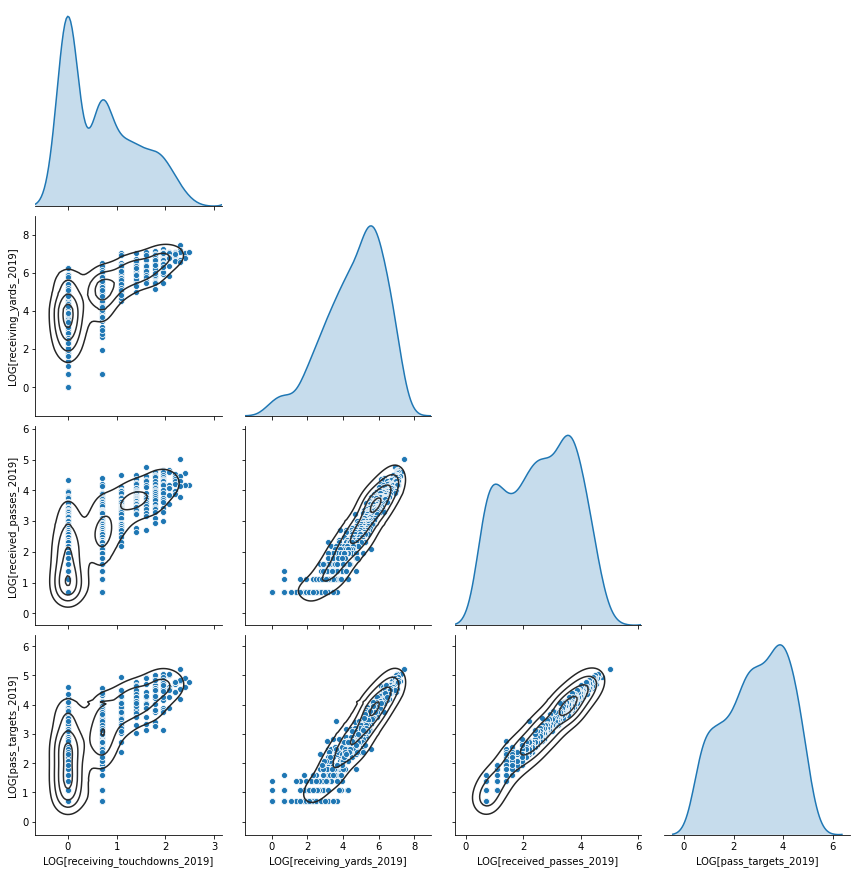

In [77]:
# pairplot the log transformed data
log_data = df[[col for col in df.columns.to_list() if 'LOG' in col]]
g = sns.pairplot(log_data, diag_kind="kde", corner=True, height = 3)
g.map_lower(sns.kdeplot, levels=4, color=".2")

# Observations
The plots of the log transformed predictor variables against each other all look linear.

In [78]:
df = log_data.copy()
y = df['LOG[receiving_touchdowns_2019]']                                       # target column y               
X = df[['LOG[receiving_yards_2019]',                                           # predictor columns
        'LOG[received_passes_2019]',
        'LOG[pass_targets_2019]']]                                             
X = sm.add_constant(X)                                                         # add constant
ols_model = sm.OLS(y, X)                                                       # assign the model architecture
fitted = ols_model.fit()                                                       # fit the model
yhat = fitted.predict(X)                                                       # predict the model
df['predicted'] = yhat                                                         # assign predicted
df['residuals'] = y - yhat                                                     # calculate and assign residuals
influence                   = fitted.get_influence()                           # get diagnostic data
df['studentized_residuals'] = influence.resid_studentized_external             # studentized residuals
df['cooks_distance']        = influence.cooks_distance[0]                      # cook's distance
summary = fitted.summary()                                                     # make the summary

print(summary)

                                  OLS Regression Results                                  
Dep. Variable:     LOG[receiving_touchdowns_2019]   R-squared:                       0.546
Model:                                        OLS   Adj. R-squared:                  0.543
Method:                             Least Squares   F-statistic:                     195.4
Date:                            Thu, 12 Nov 2020   Prob (F-statistic):           3.50e-83
Time:                                    10:29:31   Log-Likelihood:                -341.77
No. Observations:                             491   AIC:                             691.5
Df Residuals:                                 487   BIC:                             708.3
Df Model:                                       3                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

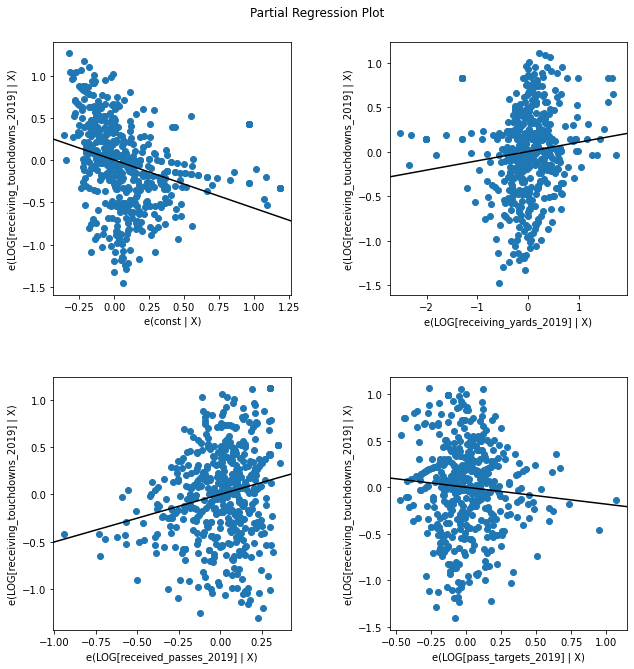

In [79]:
from matplotlib import rc
fig = plt.figure(figsize=(10,10))
fig = sm.graphics.plot_partregress_grid(fitted, fig = fig)
fig.tight_layout(pad=5)


# Next look at the correlations and scatterplot matrix among the predictors


Scatterplot Matrix



,LOG[receiving_yards_2019],LOG[received_passes_2019],LOG[pass_targets_2019]
LOG[receiving_yards_2019],1.000000,0.937258,0.940022
LOG[received_passes_2019],0.937258,1.000000,0.984846
LOG[pass_targets_2019],0.940022,0.984846,1.000000


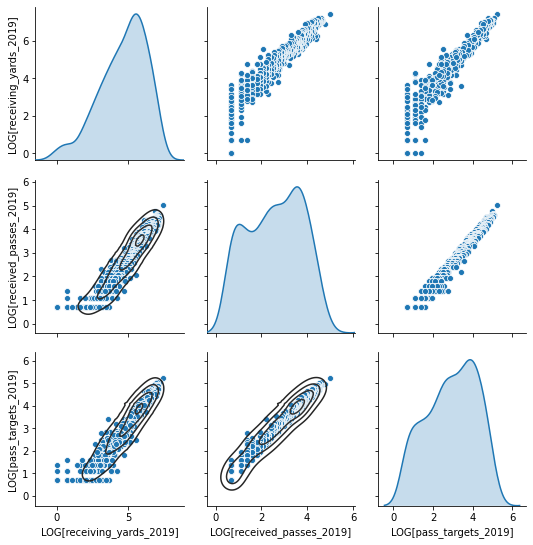

In [80]:
# pairplot the log transformed data

X = df[['LOG[receiving_yards_2019]',                                           # predictor columns
        'LOG[received_passes_2019]',
        'LOG[pass_targets_2019]']]  

draw_correlations(X)

### Observations from the two log transformed predictors
- Notice that the correlations range from 0.97258 to 0.984846
- We shall see next that these very high correlations between the predictors is the reason that most of the regression coefficients are NOT statistically significant.

### Notes
- As the correlations amongst the predictors increase, it gets harder and harder to separate and isolate the effects of each predictor on Y.
- This leads us to introduce the concept of multicollinearity

 # Multicollinearity
 SOURCE: https://en.wikipedia.org/wiki/Multicollinearity
- <b>Multicollinearity</b> is a statistical phenomenon in which two or more <b>predictor variables</b> in a multiple regression model are <b>highly correlated</b>, meaning that one can be linearly predicted
from the others with a non trivial degree of accuracy. In this situation the coefficient estimates may change erratically in response to small changes in the model or the data.


- <b>Multicollinearity</b> does not reduce the predictive power or reliability of the model as a whole, at least within the sample data themselves; it only <b>affects calculations regarding individual predictors</b>. <i>That is, a multiple regression model with correlated predictors can indicate how well the entire bundle of predictors predicts the outcome variable, but it may not give valid results about any individual predictor, or about which predictors are redundant with respect to others.</i>

- <b>Collinearity</b> is a linear relationship between <b>two</b> explanatory variables. Two variables are perfectly collinear if there is an exact linear relationship between the two.

- Multicollinearity refers to a situation in which two or more explanatory variables in a multiple regression model are highly linearly related.

# Indicators that multicollinearity may be present in a model

- <b>Large changes in the estimated regression coefficients</b> when a predictor variable is added or deleted

- <b>Insignificant regression coefficients</b> for the affected variables in the multiple regression, but a rejection of the joint hypothesis that those coefficients are all zero (based on Analysis of Variance)

- If a multiple regression finds <b>an insignificant coefficient</b> of a particular explanatory variable, yet a simple linear regression of the explained variable on this explanatory variable shows its coefficient to be significantly different from zero, this situation indicates multicollinearity in the multiple regression model.

- Regression coefficients are of the opposite sign that what is expected (e.g., negative instead of positive as in the example with Tweets as predictors)

# In other words...
Multicollinearity does not reduce the predictive power of the model over-all.  The over-all model is fine.  If you are just interested in predictions, and you don't care about how to figure out what the most important effects are then you are fine. If you are trying to understand the impact of the individual coefficients, then you have a problem.


# Variance Inflation Factors

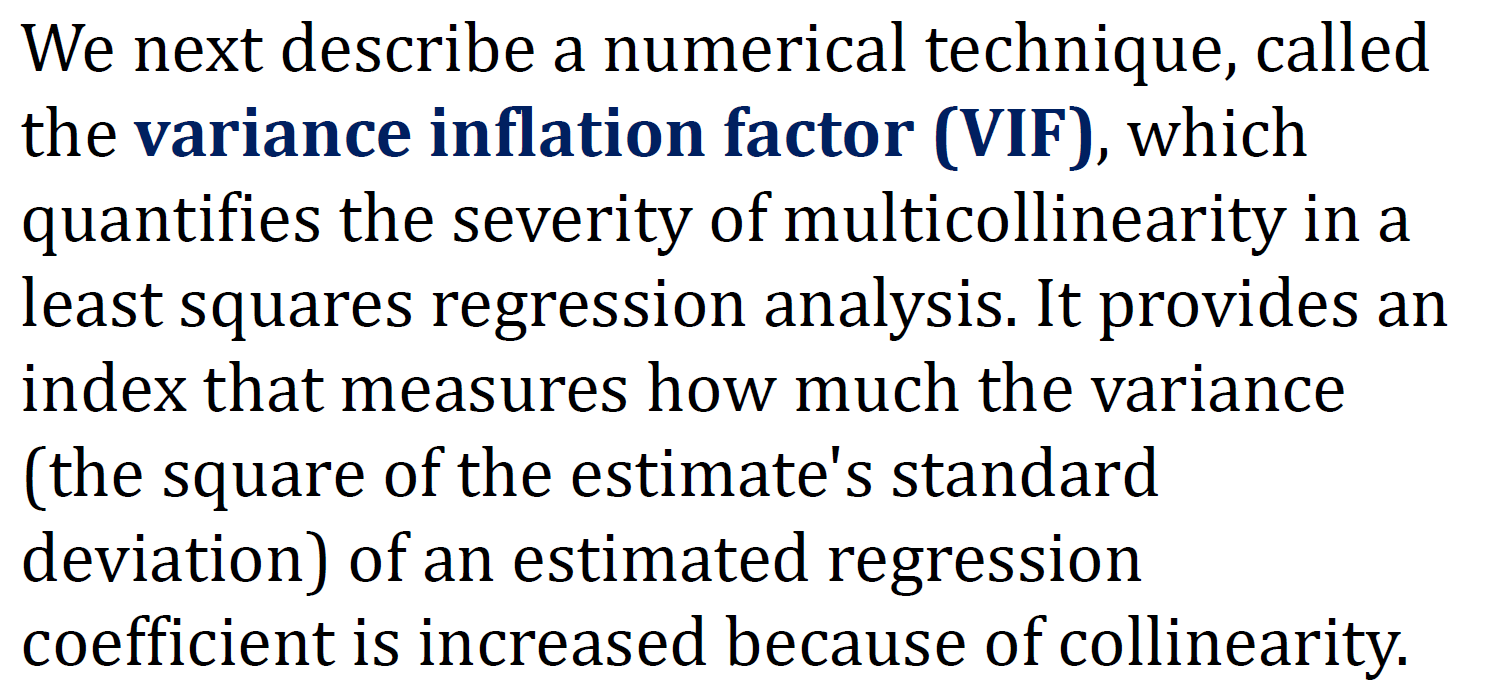

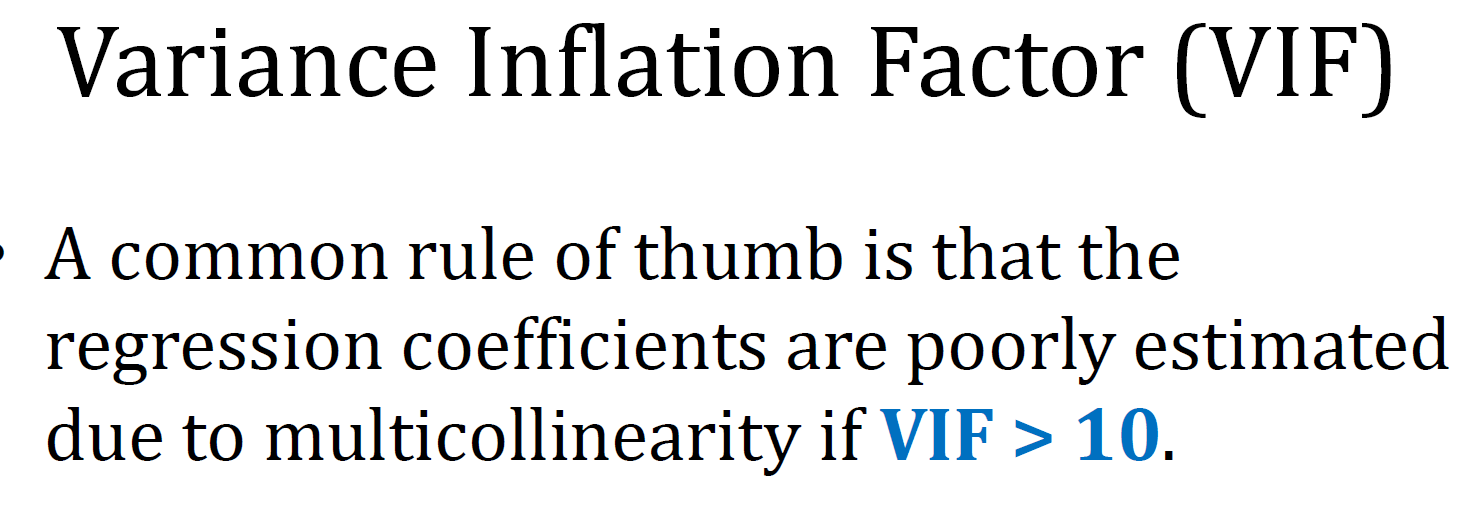

My proff once said that if you have VIF's in your model above 100 "I'm going to be talking about you at dinner parties."  That means you are throwing the kitchen sink at it...

In [81]:
def get_vifs(X):
    
    from statsmodels.stats.outliers_influence import variance_inflation_factor
        
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    
    return vif

In [82]:
X.head()

,LOG[receiving_yards_2019],LOG[received_passes_2019],LOG[pass_targets_2019]
0,7.453562,5.010635,5.225747
1,6.913737,4.762174,4.962845
2,7.061334,4.653960,5.017280
3,7.090077,4.653960,5.010635
4,7.019297,4.615121,5.036953


## It's obvious that pass targets will be correlated to passes recieved.  Will we get a number above 100?

In [83]:
get_vifs(X)

,VIF Factor,features
0,51.905029,LOG[receiving_yards_2019]
1,174.569018,LOG[received_passes_2019]
2,231.271155,LOG[pass_targets_2019]


In [87]:
X.head()

,const,receiving_yards_2019,received_passes_2019,pass_targets_2019
0,1.0,1725,149,185
1,1.0,1005,116,142
2,1.0,1165,104,150
3,1.0,1199,104,149
4,1.0,1117,100,153


In [96]:
X = df[['receiving_yards_2019','received_passes_2019','pass_targets_2019']]
get_vifs(X)

,VIF Factor,features
0,24.601796,receiving_yards_2019
1,57.563035,received_passes_2019
2,84.366951,pass_targets_2019


In [97]:
X = X[['receiving_yards_2019','received_passes_2019']]
get_vifs(X)

,VIF Factor,features
0,16.753337,receiving_yards_2019
1,16.753337,received_passes_2019


In [98]:
X = df[[                                           # predictor columns
        'received_passes_2019',
        'pass_targets_2019']]  
get_vifs(X)

,VIF Factor,features
0,57.452226,received_passes_2019
1,57.452226,pass_targets_2019


In [91]:
X = X[['received_passes_2019','pass_targets_2019']]
get_vifs(X)

KeyError: "['pass_targets_2019'] not in index"

### conclusion
The VIF's are much greater than 10, the regression coefficients (in the model based on the log transformed data) are very poorly estimated due to multicollinearity.

## VIF Study - Let's look at the Non Transformed Values

In [84]:

df = recieving_data[['receiving_touchdowns_2019','receiving_yards_2019', 'received_passes_2019','pass_targets_2019']]

y = df['receiving_touchdowns_2019']                                       # target column y  

X = df[['receiving_yards_2019',                                           # predictor columns
        'received_passes_2019',
        'pass_targets_2019']]

X = sm.add_constant(X)                                                         # add constant
ols_model = sm.OLS(y, X)                                                       # assign the model architecture
fitted = ols_model.fit()                                                       # fit the model
yhat = fitted.predict(X)                                                       # predict the model
df['predicted'] = yhat                                                         # assign predicted
df['residuals'] = y - yhat                                                     # calculate and assign residuals
influence                   = fitted.get_influence()                           # get diagnostic data
df['studentized_residuals'] = influence.resid_studentized_external             # studentized residuals
df['cooks_distance']        = influence.cooks_distance[0]                      # cook's distance
summary = fitted.summary()                                                     # make the summary

print(summary)
display(get_vifs(X))

                                OLS Regression Results                               
Dep. Variable:     receiving_touchdowns_2019   R-squared:                       0.701
Model:                                   OLS   Adj. R-squared:                  0.699
Method:                        Least Squares   F-statistic:                     380.2
Date:                       Thu, 12 Nov 2020   Prob (F-statistic):          3.79e-127
Time:                               10:37:22   Log-Likelihood:                -794.24
No. Observations:                        491   AIC:                             1596.
Df Residuals:                            487   BIC:                             1613.
Df Model:                                  3                                         
Covariance Type:                   nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

,VIF Factor,features
0,1.967989,const
1,14.988823,receiving_yards_2019
2,30.834579,received_passes_2019
3,46.578275,pass_targets_2019


### conclusion
The VIF's are much greater than 10, the regression coefficients (in the model based on the non-transformed data) are very poorly estimated due to multicollinearity.

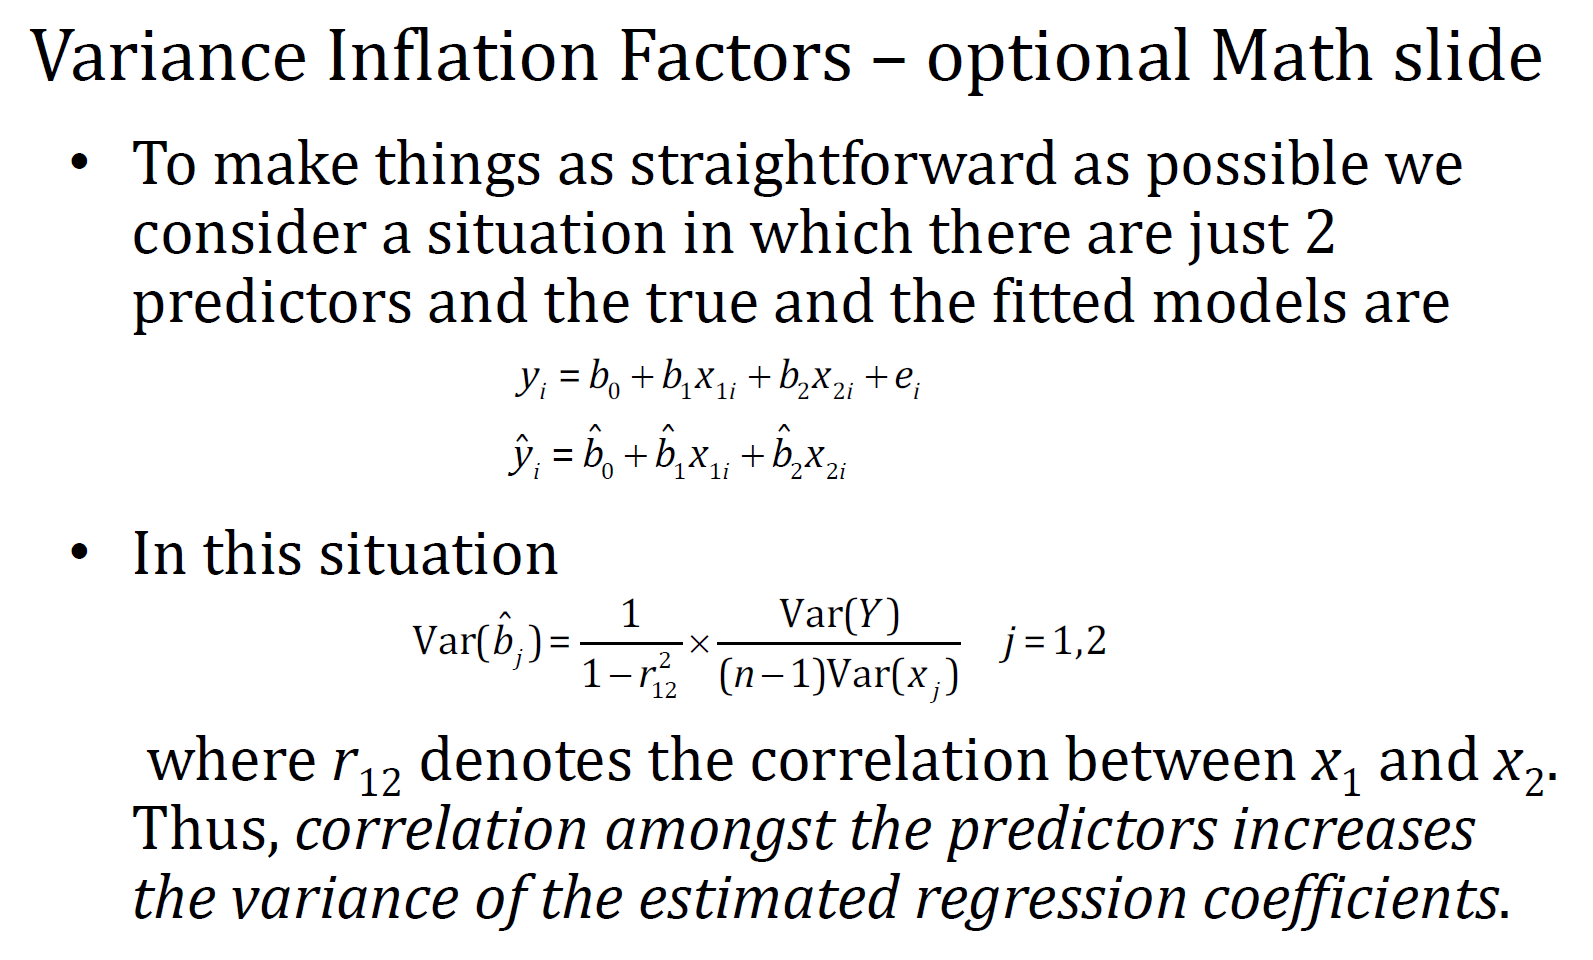

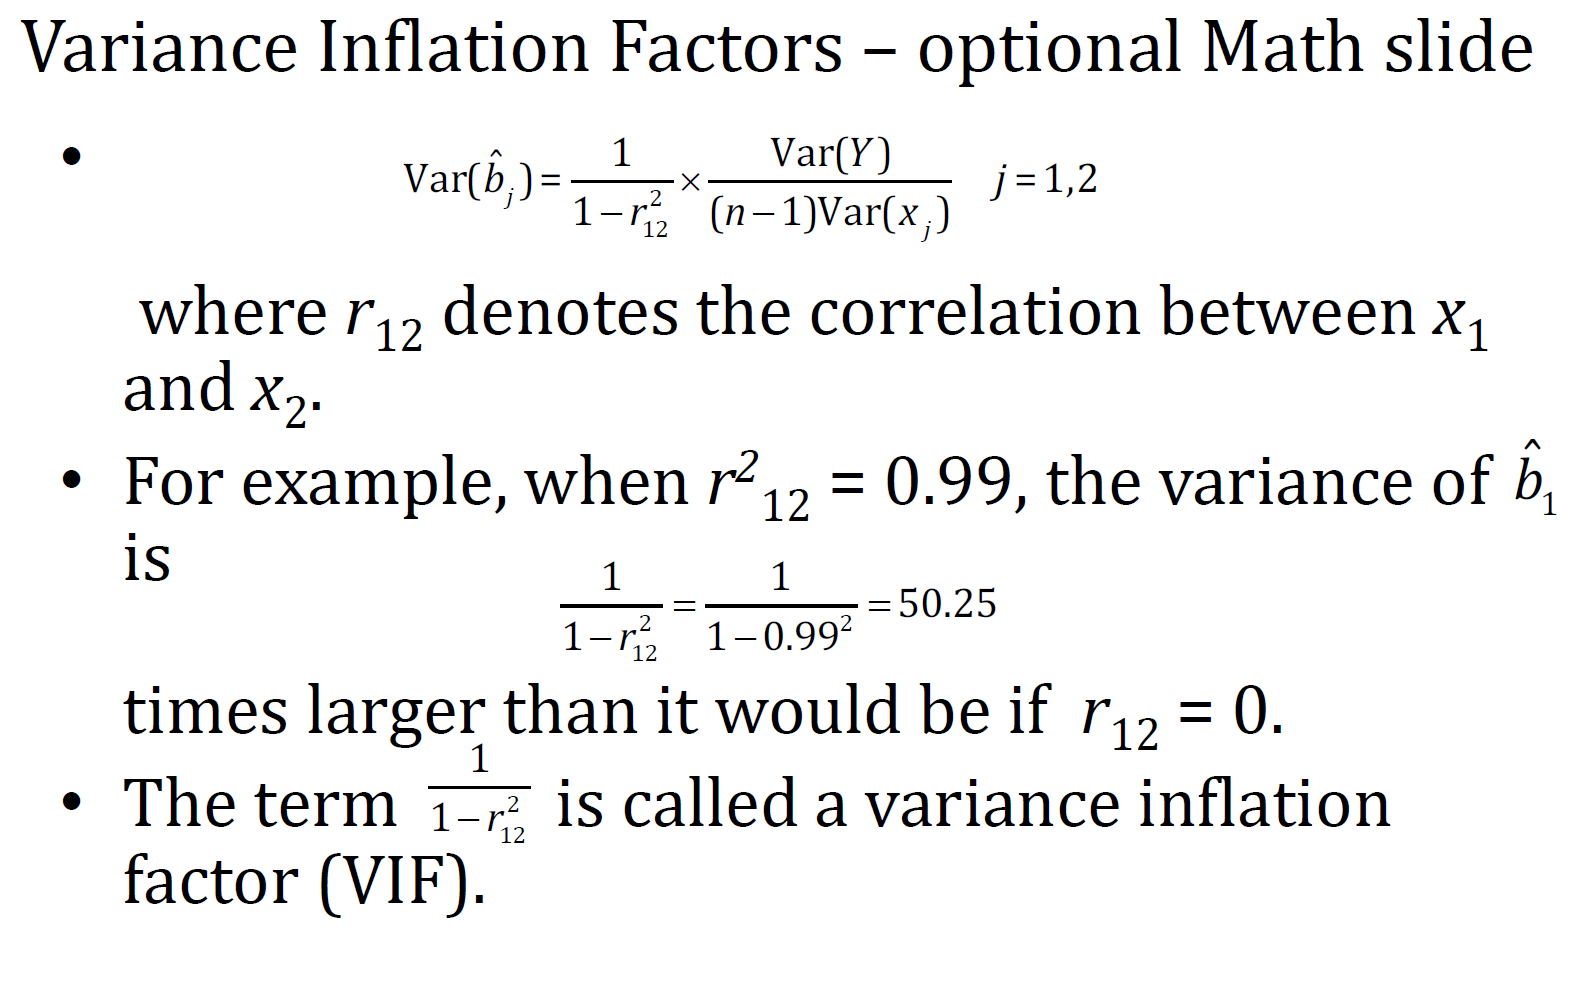